In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import sys
sys.path.append('../src')

In [4]:
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import pandas as pd
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator
from spaceoracle.oracles import SpaceTravLR


In [5]:
adata_train = sc.read_h5ad('.cache/day3_lymph_rep_1.h5ad')
# adata_train = sc.read_h5ad('/Users/koush/Projects/SpaceOracle/notebooks/.cache/adata_train.h5ad')
adata_train

AnnData object with n_obs × n_vars = 11567 × 3020
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [7]:
estimator = SpatialCellularProgramsEstimator(
    adata=adata_train,
    target_gene='Pax5',
    layer='imputed_count'
)

In [8]:
%%time

estimator.fit(num_epochs=200, threshold_lambda=1e-5, learning_rate=5e-4)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Fitting Pax5 with 205 modulators
	37 Transcription Factors
	58 Ligand-Receptor Pairs
	110 TranscriptionFactor-Ligand Pairs
0: 0.8455 | 0.8336
1: 0.8800 | 0.8574
2: 0.8945 | 0.8785
3: 0.8319 | 0.7971
4: 0.9392 | 0.9331
5: 0.9182 | 0.9126
6: 0.9349 | 0.9126
CPU times: user 3min 18s, sys: 38.4 s, total: 3min 56s
Wall time: 11min 13s


In [9]:
estimator.betadata.to_parquet(f'./models/{estimator.target_gene}_betadata.parquet')

In [10]:
# so = SpaceTravLR(adata=adata_train, save_dir = './models')
so = SpaceTravLR(adata=adata_train, save_dir = '/Users/koush/Downloads/models_v2')
gene_mtx = so.adata.layers[estimator.layer]
beta_dict = {estimator.target_gene: so._get_betas(estimator.target_gene)}

gex_df = estimator.adata.to_df(layer=estimator.layer)
beta_dict = so._get_wbetas_dict(beta_dict, gex_df)
wbetas = beta_dict[estimator.target_gene].wbetas[1]

xy = pd.DataFrame(
    adata_train.obsm['spatial'], index=adata_train.obs.index, columns=['x', 'y'])

df = wbetas \
        .join(adata_train.obs) \
        .join(xy) \
        .join(gex_df)

# df = df.join(beta_dict[estimator.target_gene].betas)

In [11]:
markers = ['o', 'X', '<', '^', 'v', 'D', '>']
cmaps = dict(zip(range(7), ['rainbow', 'cool', 'RdYlGn_r', 'spring_r', '', 'PuRd', 'Reds']))
cell_map = dict(zip(df['rctd_cluster'], df['rctd_celltypes']))

def plot(plot_for, clusters=[0, 1, 2], with_expr=False, size=25, linewidth=0.5, alpha=1, edgecolor='black', dpi=100, figsize=(11, 9), fig=None, axes=None):

    if fig is None or axes is None:
        fig, (ax, cax) = plt.subplots(1, 2, dpi=dpi, figsize=figsize, gridspec_kw={'width_ratios': [4, 0.5]})
    else:
        ax, cax = axes

    # Get cluster-specific min/max for individual colorbar scales
    norms = {}
    for i in clusters:
        cluster_data = df[df.rctd_cluster==i][plot_for]
        vmin = cluster_data.min()
        vmax = cluster_data.max()
        norms[i] = plt.Normalize(vmin=vmin, vmax=vmax)

    for i in clusters:
        betas_df = df[df.rctd_cluster==i]
        missing_columns = list(set(estimator.train_df.columns) - set(betas_df.columns))
        betas_df = betas_df.join(estimator.train_df[missing_columns])

        if with_expr:
            betas_df[plot_for] = betas_df[plot_for]*betas_df[plot_for.replace('beta_', '')]

        sns.scatterplot(
            data=betas_df,
            x='x', 
            y='y',
            hue=plot_for,
            palette=cmaps[i],
            s=size,
            alpha=alpha,
            # alpha= 1 if i == 2 else 0.25,
            linewidth=linewidth,
            edgecolor=edgecolor,
            legend=False,
            style='rctd_celltypes',
            markers=markers,
            ax=ax
        )
    ax.axis('off')

    cbar_width = 0.15  # Width of each colorbar
    cbar_height = 0.8 / len(cmaps)  # Height of each colorbar
    for i, cmap_name in cmaps.items():
        if i not in [0, 1, 2]:
            continue
        cmap = plt.get_cmap(cmap_name)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norms[i])
        sm.set_array([])
        cax_i = cax.inset_axes([0.2, 0.95 - (i+1)*cbar_height*2.5, cbar_width, cbar_height*1.5])
        cbar = fig.colorbar(sm, cax=cax_i, orientation='vertical')
        cbar.ax.tick_params(labelsize=9)  # Reduce tick label size
        cbar.ax.set_title(f'{cell_map[i]}', fontsize=12, pad=8)  # Reduce title size and padding

    cax.set_ylabel(plot_for, fontsize=8)
    cax.axis('off')

    unique_styles = sorted(set(df['rctd_celltypes']))
    style_handles = [plt.Line2D([0], [0], marker=m, color='w', markerfacecolor='gray', 
                    markersize=10, linestyle='None', alpha=1) 
                    for m in markers][:len(unique_styles)]
    ax.legend(style_handles, unique_styles, ncol=1,
        title='Cell types', loc='lower left',  
        frameon=False)

    ax.set_title(f'{plot_for} > {estimator.target_gene}', fontsize=15)
    
    return ax

In [12]:
estimator.regulators

['Atf3',
 'Bcl11a',
 'Bcl11b',
 'Bcl6',
 'Bclaf1',
 'Brca1',
 'Brf1',
 'Cebpb',
 'Cebpz',
 'Creb3l1',
 'Ctcf',
 'Egr2',
 'Egr3',
 'Fos',
 'Fosl2',
 'Gata2',
 'Hic1',
 'Irf9',
 'Klf4',
 'Klf7',
 'Mafb',
 'Mef2c',
 'Mga',
 'Nr2c2',
 'Nr2f2',
 'Pbx3',
 'Prdm1',
 'Pura',
 'Runx2',
 'Rxra',
 'Smad4',
 'Stat2',
 'Taf1',
 'Tal1',
 'Zbtb17',
 'Zbtb6',
 'Zfp524']

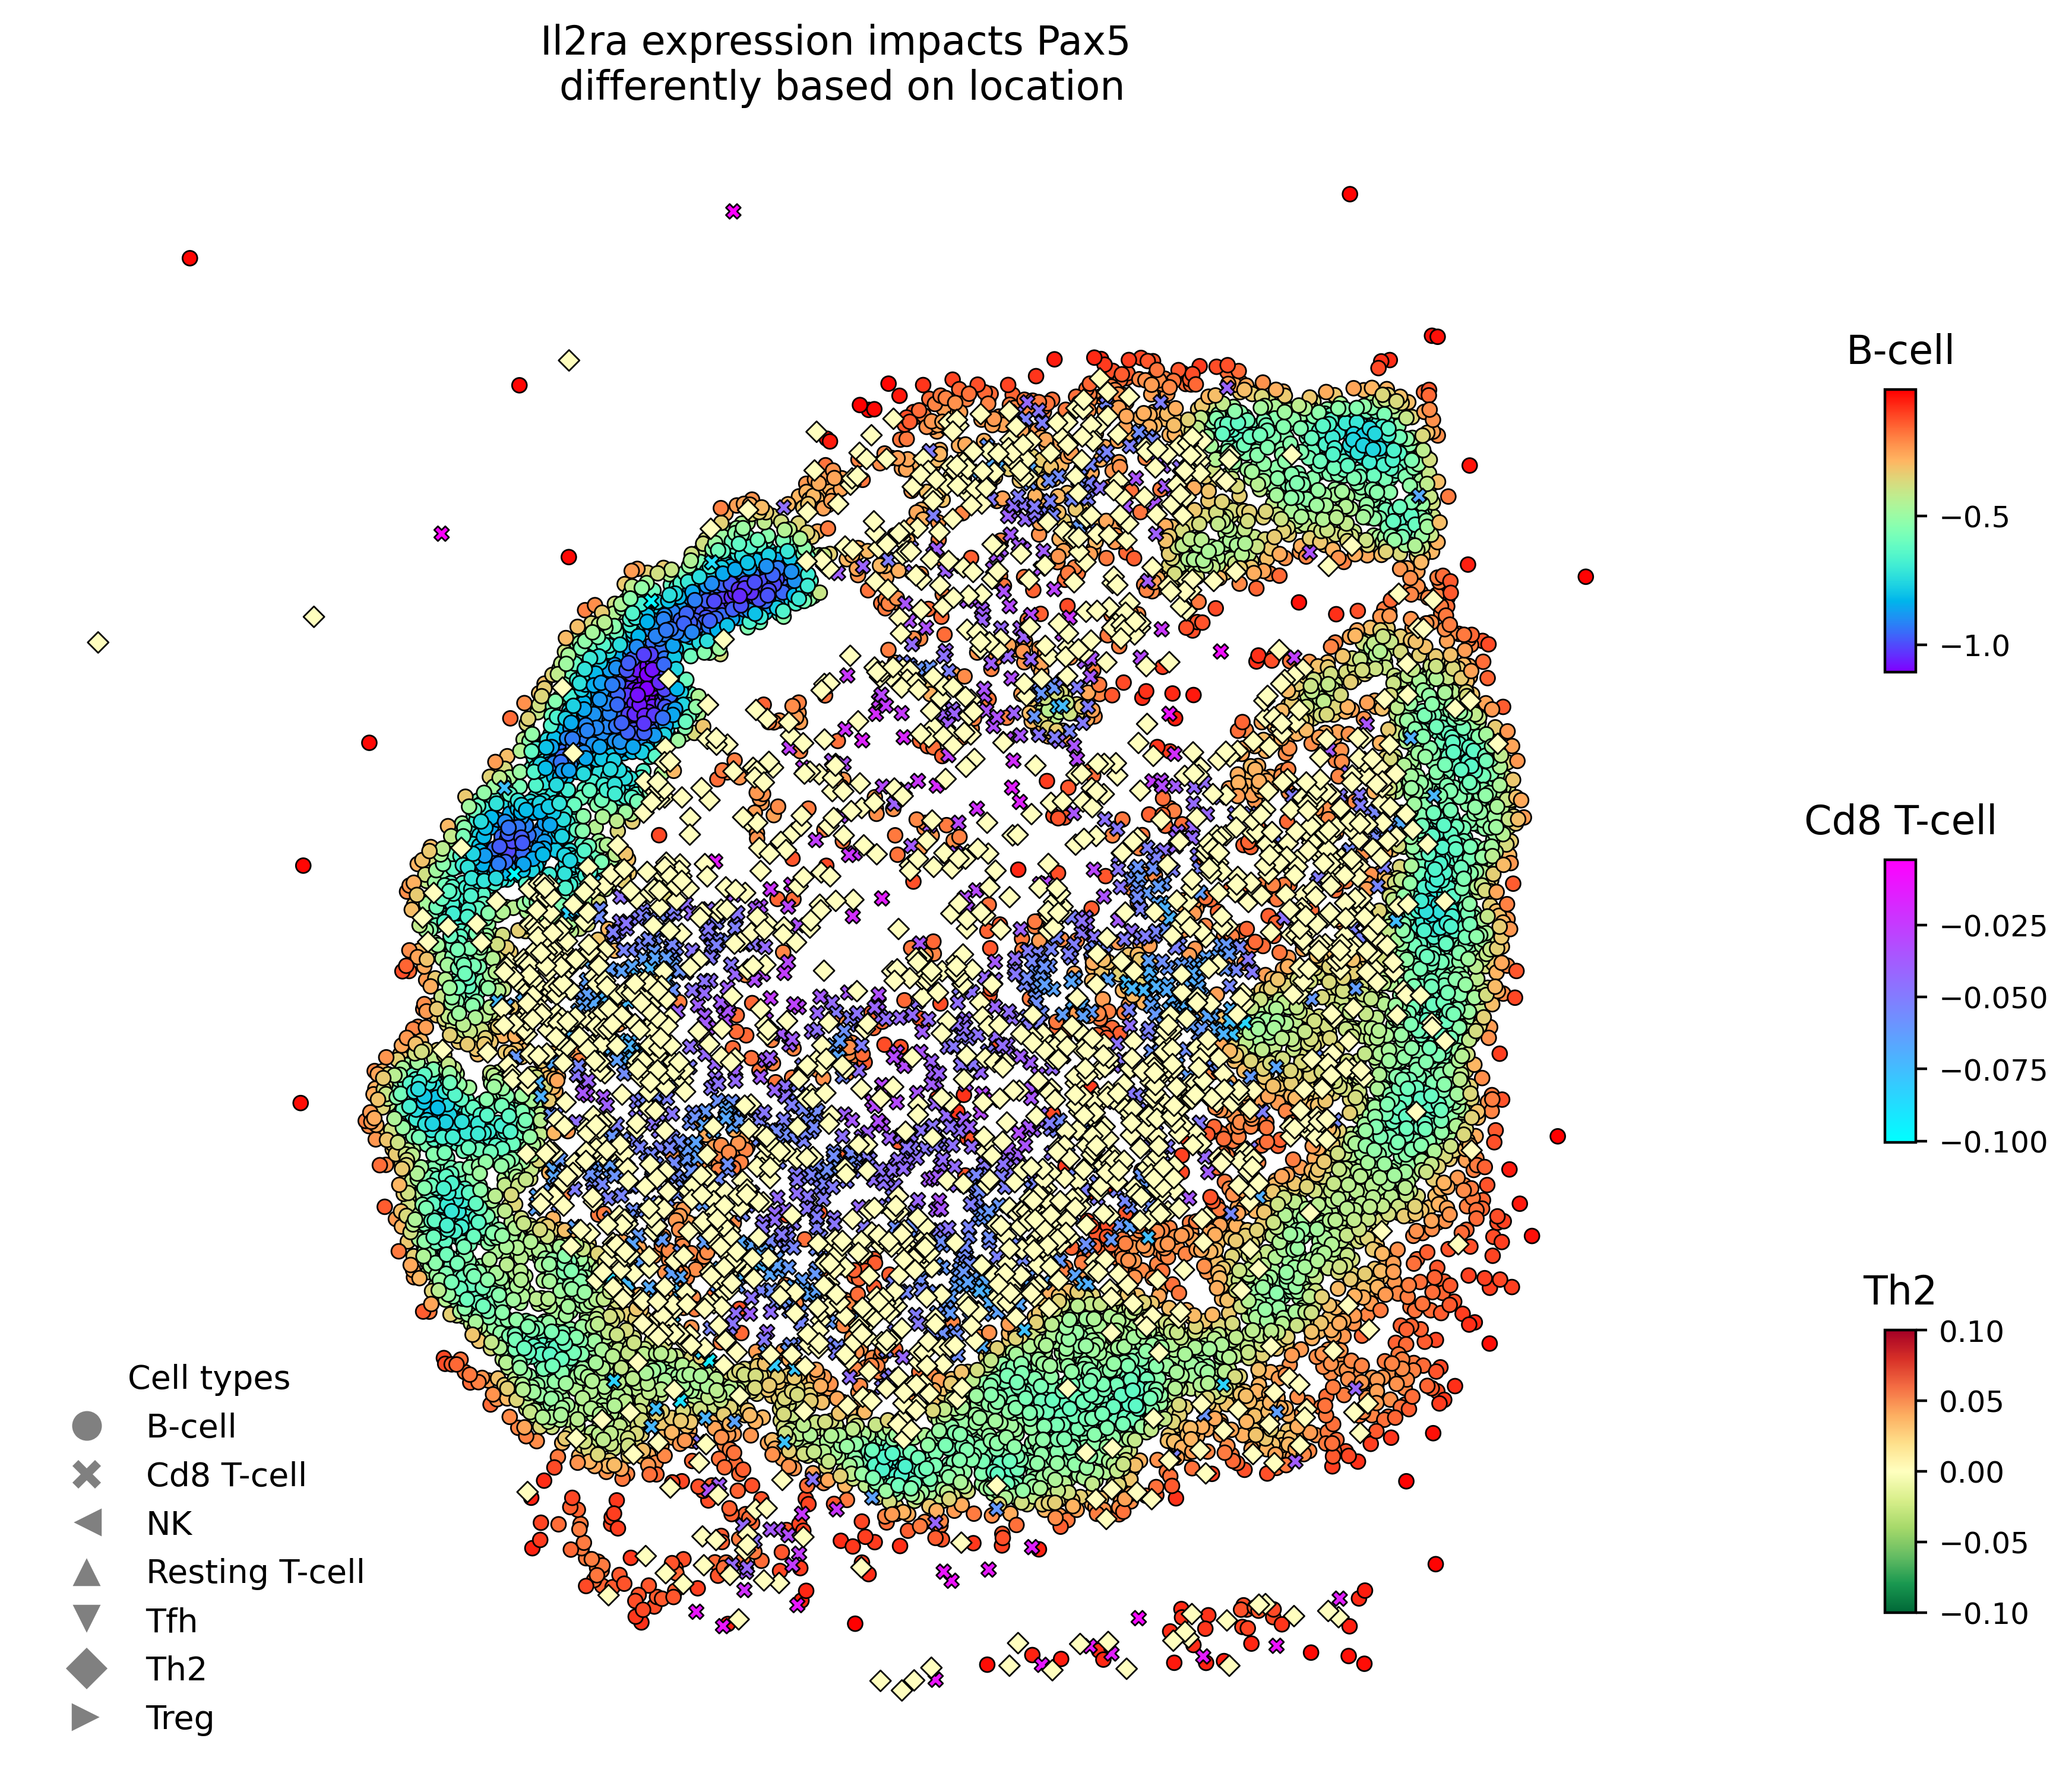

In [20]:
ax = plot('beta_Il2ra', dpi=200, size=20, with_expr=False)
ax.set_title('Il2ra expression impacts Pax5 \ndifferently based on location')
plt.show()

In [145]:
df.rctd_celltypes.value_counts()

rctd_celltypes
B-cell            7531
Th2               1785
Cd8 T-cell        1246
Tfh                323
Resting T-cell     274
Treg               241
NK                 167
Name: count, dtype: int64

In [148]:
from sklearn.cluster import KMeans

k = 4
kmeans = KMeans(n_clusters=k, random_state=1334).fit(df[df.rctd_celltypes=='Cd8 T-cell'][estimator.modulators_genes])
labels = kmeans.labels_

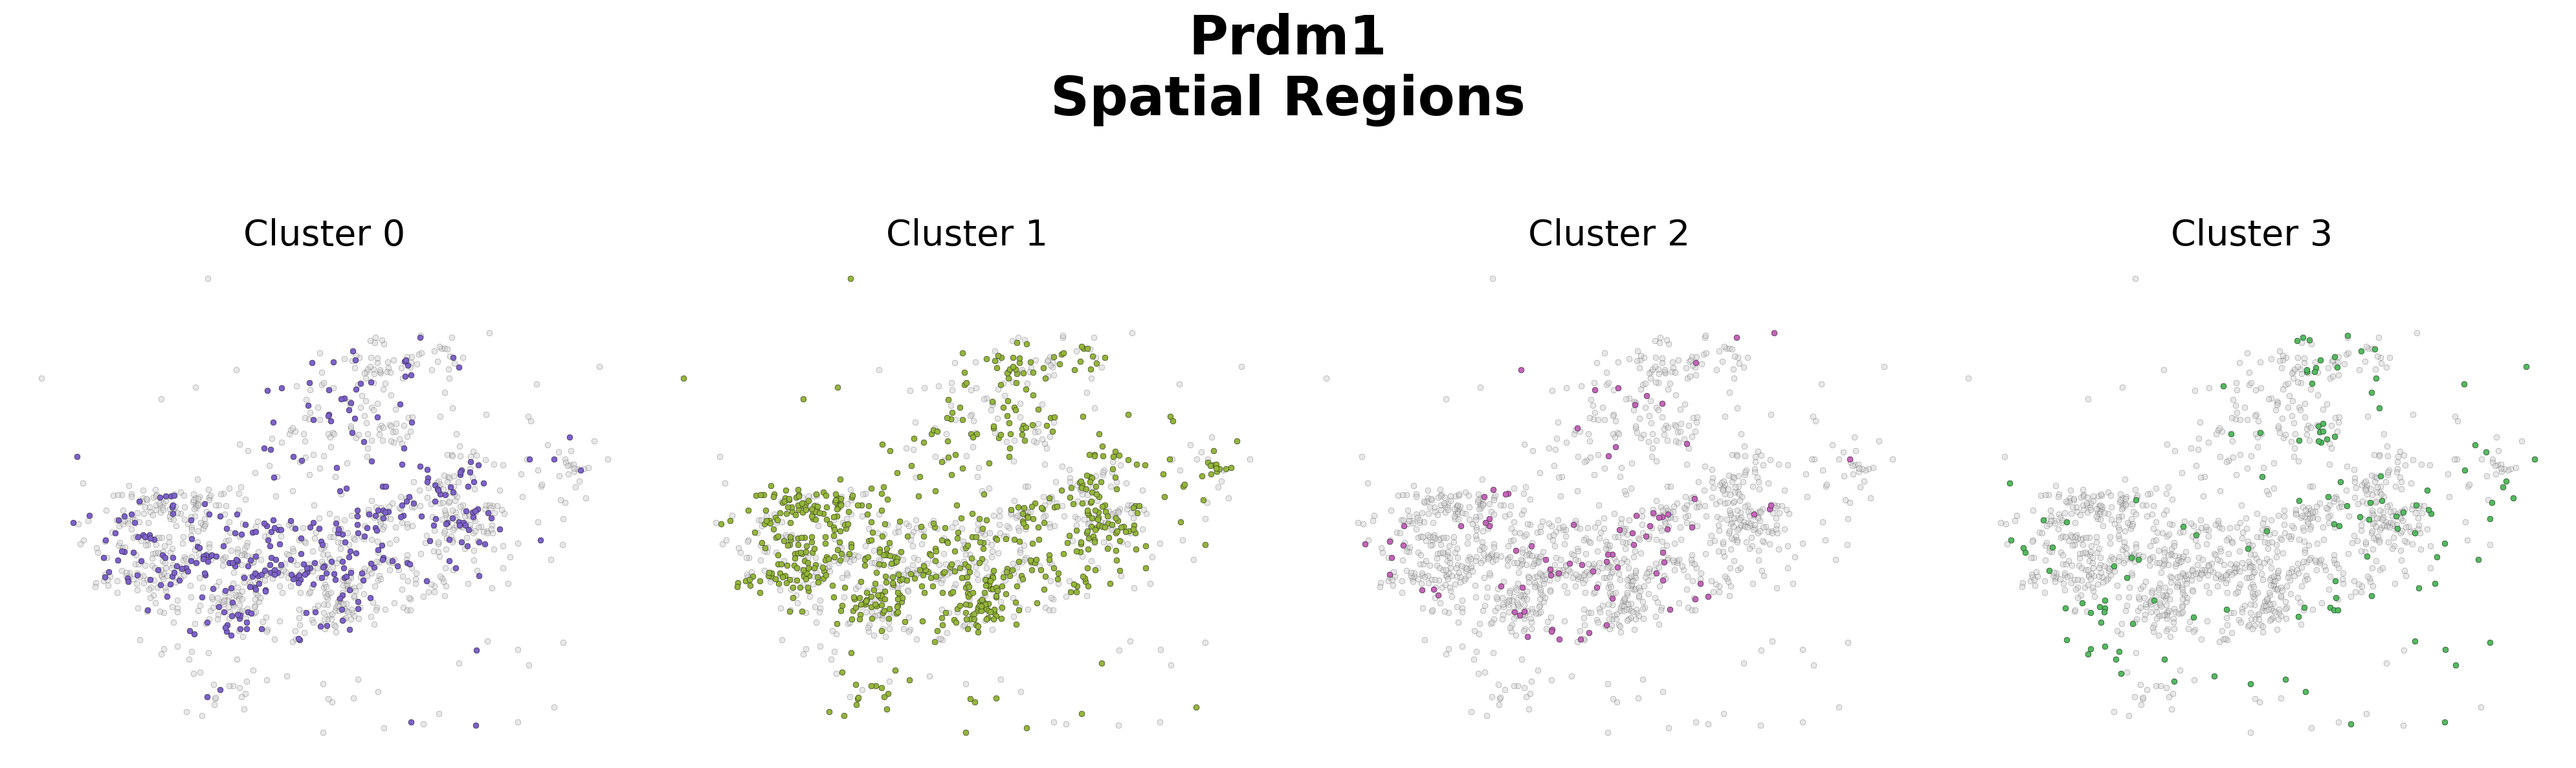

In [150]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

axes = axes.ravel()

adata = estimator.adata

# Define custom colors
colors = ["#7d61ca", "#94b53b", "#c364b9", "#53ba5f", "#d14573", "#50b49b", 
          "#cb4934", "#688bcd", "#cf7d41", "#5c7c38", "#bd6a7c", "#b49544"]

for i in range(k):
    cluster_mask = labels == i

    adata_ = adata[adata.obs.rctd_celltypes=='Cd8 T-cell']
    
    axes[i].scatter(
        adata_.obsm['spatial'][:, 0], adata_.obsm['spatial'][:, 1],
        c='lightgray', s=10, edgecolors='black', linewidth=0.15, alpha=0.5
    )
    
    axes[i].scatter(
        adata_.obsm['spatial'][cluster_mask, 0], adata_.obsm['spatial'][cluster_mask, 1],
        c=colors[i], s=10, edgecolors='black', linewidth=0.15
    )
    
    axes[i].set_title(f'Cluster {i}', fontsize=20)
    axes[i].set_xticks([])  
    axes[i].set_yticks([])  

for ax in axes:
    ax.set_frame_on(False)

plt.suptitle(f'{estimator.target_gene}\nSpatial Regions\n', fontsize=30, fontweight='bold')
plt.tight_layout()
plt.show()


In [132]:
# plt.rcParams['figure.figsize'] = (45, 3)
# plt.rcParams['figure.dpi'] = 100

# hmap = df[[
#         'beta_'+i for i in estimator.modulators if '$' in i]+[
#             'rctd_celltypes']].groupby('rctd_celltypes').mean().abs()>0
# sns.heatmap(
#     hmap.loc[:, (hmap.sum(0) > 0)],
#     square=True,
#     cbar=False,
#     linewidths=0.5,
#     linecolor='black',
#     xticklabels=True,
#     yticklabels=True,
#     cmap='Reds'
# )
# plt.title(f'Modulators for {estimator.target_gene}', fontsize=15)
# plt.tight_layout()
# plt.show()
# hmap = df[[
#         'beta_'+i for i in estimator.modulators if '#' in i]+[
#             'rctd_celltypes']].groupby('rctd_celltypes').mean().abs()>0
# sns.heatmap(
#     hmap.loc[:, (hmap.sum(0) > 0)],
#     square=True,
#     cbar=False,
#     linewidths=0.5,
#     linecolor='black',
#     xticklabels=True,
#     yticklabels=True,
#     cmap='Reds'
# )

# plt.title(f'Modulators for {estimator.target_gene}', fontsize=15)
# plt.tight_layout()
# plt.show()